# Gradient descent - OOP SPT extraction test
Created 15/05/2024

Objectives:
* Implement OOP MPO gradient descent on a small case, calculate fermionic and proj rep cohomologies.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../")

In [91]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import time

from collections import namedtuple

In [4]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt

In [17]:
from SPTOptimization.utils import (
    to_npc_array
)

from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.Optimizers.MPOGradientDescent import (
    MPOGradientDescent
)

# Load data

In [9]:
DATA_DIR_2 = r"../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [10]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [11]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

# Definitons

In [12]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [13]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [14]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [18]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [19]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [20]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [21]:
fermionic_np_symmetries = [np_I, np_JW]

In [22]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [23]:
npc_JW = fermionic_npc_symmetries[1]

In [24]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [25]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [29]:
cases_non_triv_proj_rep = dict()
psi = loaded_data_non_triv_proj_rep[0]

for i, l in enumerate(symmetry_actions):

    for j, s in enumerate(l):
        case = SymmetryActionWithBoundaryUnitaries(
            psi,
            s*40,
            left_symmetry_index=60,
            left_boundary_unitaries=[np_I, np_00]*1,
            right_boundary_unitaries=[np_00, np_I]*1
        )

        cases_non_triv_proj_rep[(i, j)] = case

In [31]:
for c in cases_non_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

# Get MPO solutions

## Attempt 1

In [62]:
num_sites = 6

unitarity_learning_rate = 1
overlap_learning_rate = 100

num_iterations = 2000
num_followup_iterations = 200
bond_dimension = 6
num_seeds = 10

In [63]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [64]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 5) and (overlap > 0.9):
        return True
    return False

In [65]:
def get_diverging_sol(unitarity, overlap):
    if unitarity > 1e10:
        return True
    if overlap > 1e10:
        return True
    return False

In [66]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-3),
    'beta_1': scipy.stats.uniform(0.2, 0.25),
    'beta_2': scipy.stats.uniform(0.2, 0.2),
    'overlap_learning_rate': scipy.stats.randint(1, 200)
}

In [67]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [68]:
opt_dict = dict()

for k, case in cases_non_triv_proj_rep.items():
    if (k[1] != 0):
        start = time.time()
        print(k)
    
        opt_dict[k] = opt

        results_dict = dict()
        new_seed_needed = True
        good_sol_found = False

        l=0
        while new_seed_needed:
            start = time.time()
            hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
            print(hyperparams)


            opt = MPOGradientDescent(
                case,
                num_sites,
                bond_dimension,
                unitarity_learning_rate,
                hyperparams['overlap_learning_rate'],
                (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2']),
                random_initial_mpo=True
            )

            j = 0
            need_more_iterations = True
            while need_more_iterations:
                opt.grad_desc_one_step()
    
                j += 1

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
                diverging_sol = get_diverging_sol(unitarity, overlap)
                need_more_iterations = (
                    (not good_sol_found)
                    and (not diverging_sol)
                    and (j<num_iterations)
                )

            if good_sol_found:
                for _ in range(num_followup_iterations):
                    opt.grad_desc_one_step()

            end = time.time()

            # Saving multiple copies of MPS? This could blow up memory...!
            current_results = {
                'time': (end-start),
                'good_sol': good_sol_found,
                'opt': opt
            }
            
            results_dict[HyperParams(**hyperparams)] = current_results
            print(end - start)
            print(np.real(unitarity))
            print(overlap)
            print()

            l += 1
            new_seed_needed = (
                (not good_sol_found)
                and (l<num_seeds)
            )

        opt_dict[k] = results_dict

(0, 1)
{'alpha': 0.00010738222439568828, 'beta_1': 0.44059846912558376, 'beta_2': 0.37447443567042404, 'overlap_learning_rate': 99}
451.00654315948486
0.020488200290060377
8.31439638828039e-05

{'alpha': 0.0008887689707016441, 'beta_1': 0.3142096714168725, 'beta_2': 0.35763508712163083, 'overlap_learning_rate': 198}
435.729948759079
4.881229614242784
0.9457255722946624

(0, 2)
{'alpha': 0.0005537949086336584, 'beta_1': 0.3198223683718352, 'beta_2': 0.2415707728470976, 'overlap_learning_rate': 140}
446.93121910095215
0.03993342099397523
7.997141227565345e-05

{'alpha': 0.00033153164258188135, 'beta_1': 0.30708914230459305, 'beta_2': 0.23873831945998533, 'overlap_learning_rate': 177}
347.92000102996826
244.17690853698537
0.877225063204379

{'alpha': 0.00048051142930698057, 'beta_1': 0.36005830923992543, 'beta_2': 0.35709841679989346, 'overlap_learning_rate': 117}
215.76907873153687
0.07929494162323181
4.697523294442979e-05

{'alpha': 0.0003723403275685927, 'beta_1': 0.300736920654034, 'b

This is painfully slow... what's taking so long? Profile?

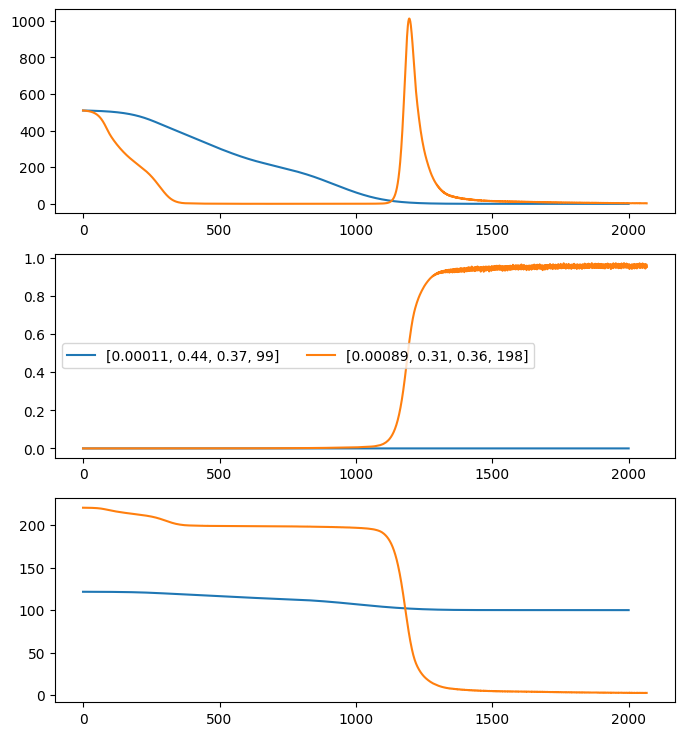

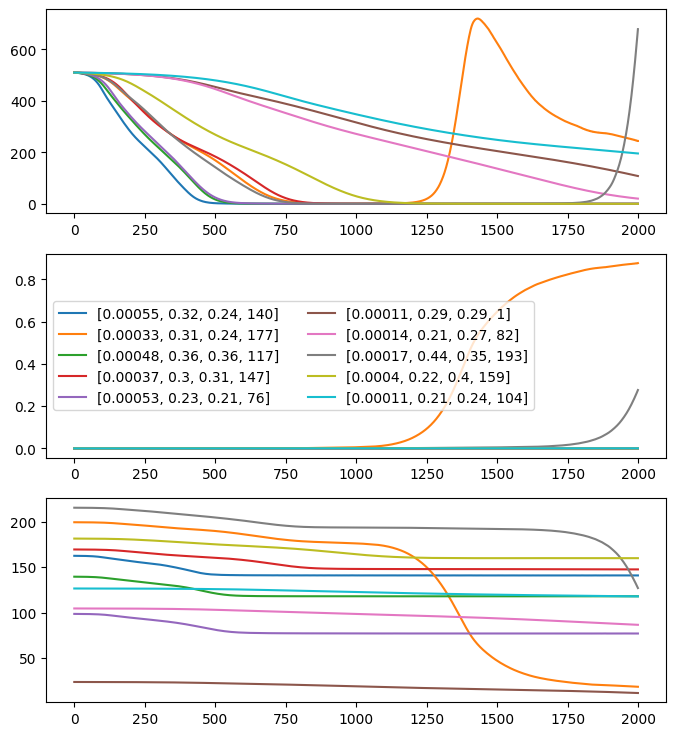

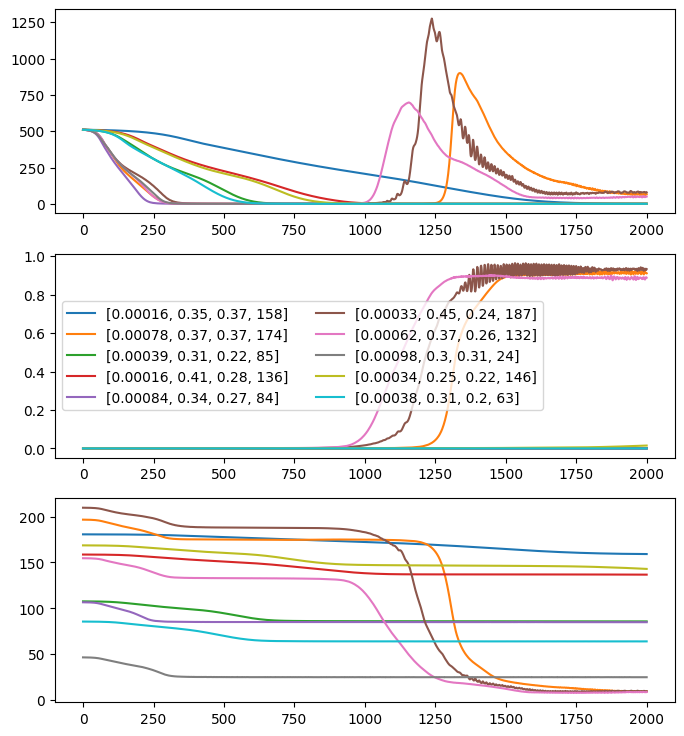

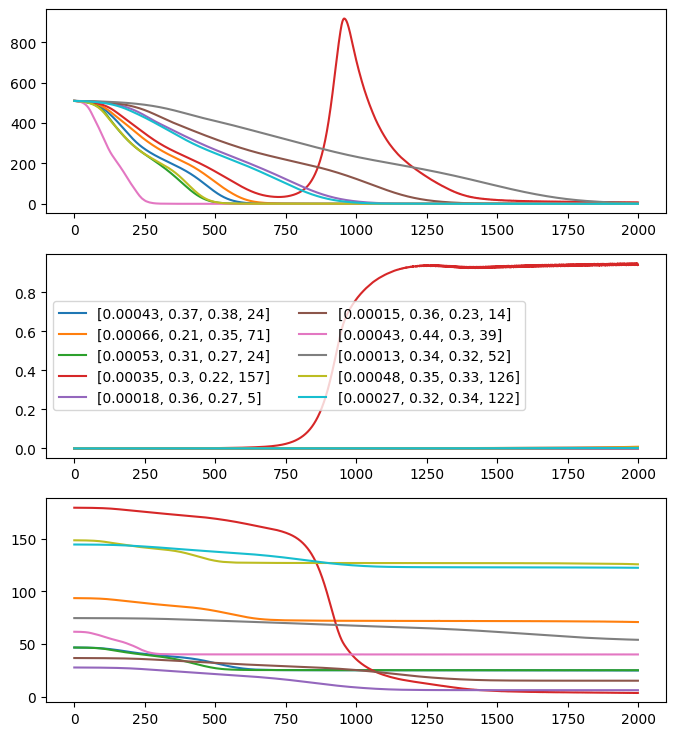

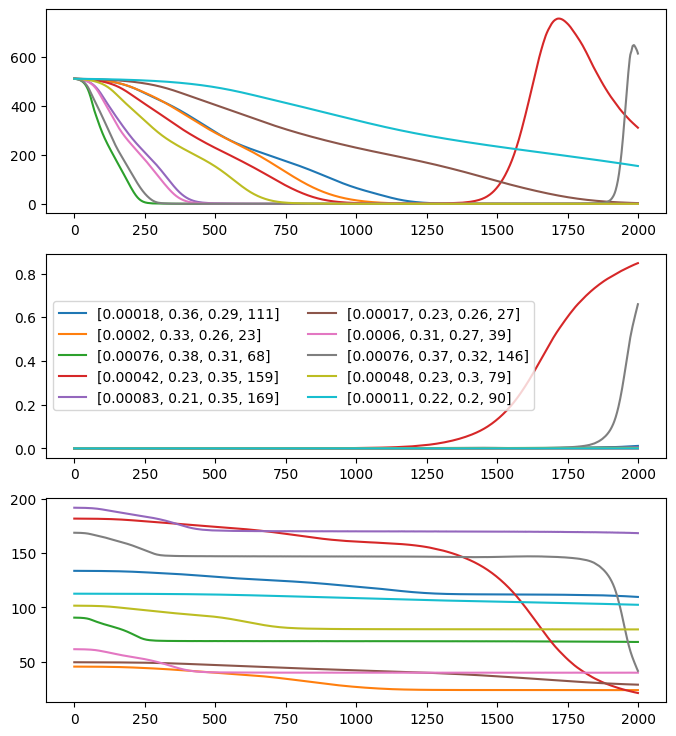

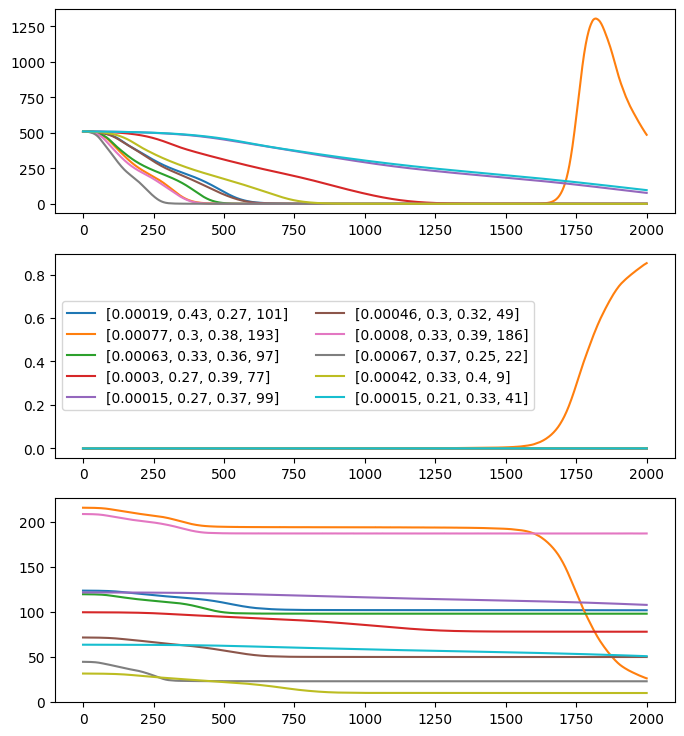

In [98]:
for key, v1 in opt_dict.items():
    
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))
    
    for k, v in v1.items():
        opt = v['opt']
        label=[np.round(x, 2) for x in k]
        label[0] = np.round(k[0], 5)
        ax1.plot(opt.unitarity_scores)
        ax2.plot(opt.mpo_expectations, label=label)
        opt.compute_training_losses()
        ax3.plot(opt.training_losses)
    
    ax2.legend(loc='center left', ncols=2)

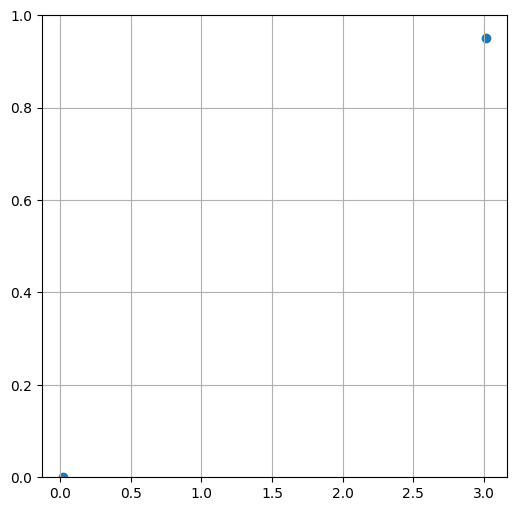

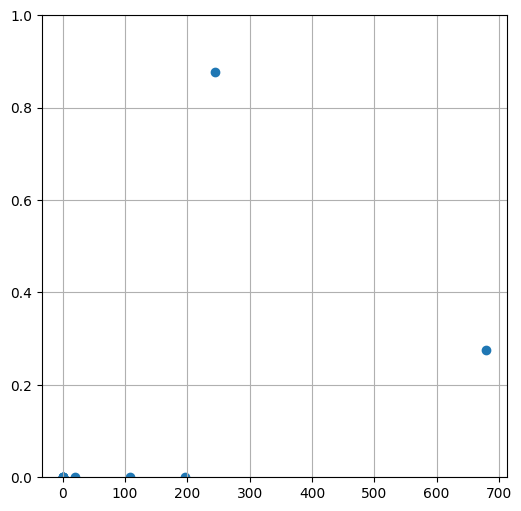

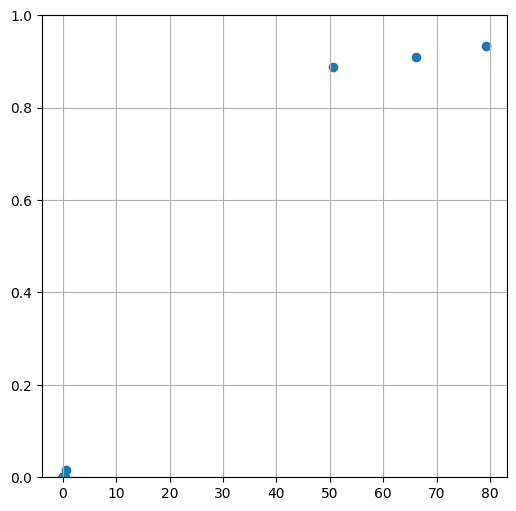

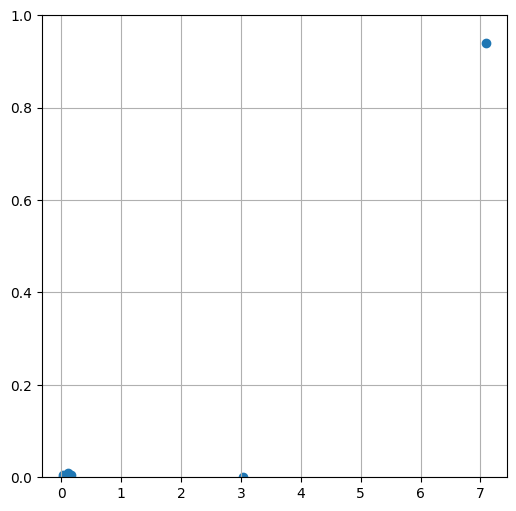

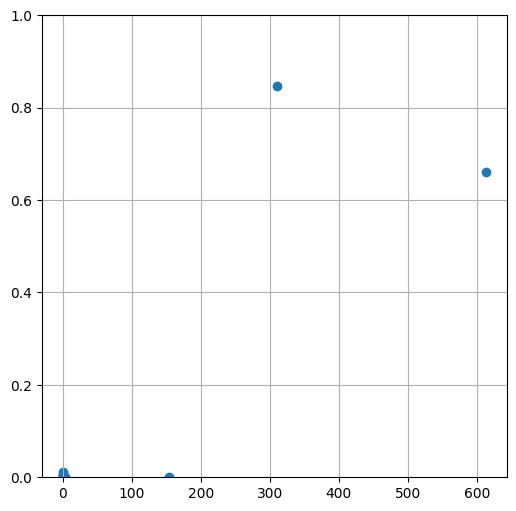

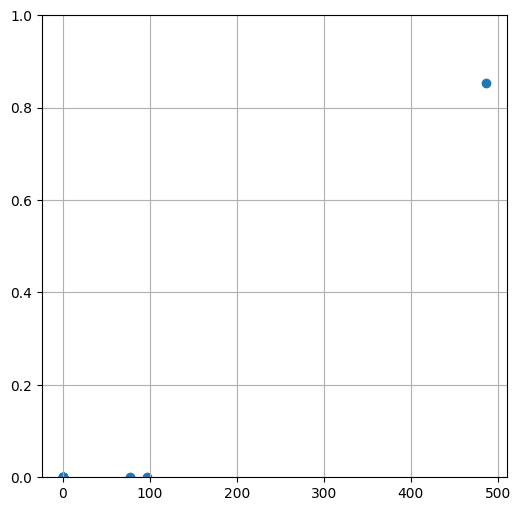

In [101]:
for key, v1 in opt_dict.items():
    
    fig, ax = plt.subplots(figsize=(6, 6))

    final_unitarities = list()
    final_mpo_expectations = list()
    
    for k, v in v1.items():
        opt = v['opt']
        final_unitarities.append(opt.unitarity_scores[-1])
        final_mpo_expectations.append(opt.mpo_expectations[-1])
    
    ax.scatter(final_unitarities, final_mpo_expectations)
    ax.set_ylim(0, 1)
    ax.grid()

## Attempt 2

In [102]:
num_sites = 6

unitarity_learning_rate = 1
overlap_learning_rate = 100

num_iterations = 2000
num_good_sol_followup_iterations = 200
num_potential_sol_followup_iterations = 1000
bond_dimension = 6
num_seeds = 10

In [103]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [104]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [105]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(3e-4, 3e-3),
    'beta_1': scipy.stats.uniform(0.15, 0.25),
    'beta_2': scipy.stats.uniform(0.2, 0.2),
    'overlap_learning_rate': scipy.stats.randint(80, 250)
}

In [106]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [107]:
opt_dict = dict()

for k, case in cases_non_triv_proj_rep.items():
    if (k[1] != 0):
        start = time.time()
        print(k)

        results_dict = dict()
        new_seed_needed = True
        good_sol_found = False

        l=0
        while new_seed_needed:
            start = time.time()
            hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
            print(hyperparams)


            opt = MPOGradientDescent(
                case,
                num_sites,
                bond_dimension,
                unitarity_learning_rate,
                hyperparams['overlap_learning_rate'],
                (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2']),
                random_initial_mpo=True
            )

            j = 0
            need_more_iterations = True
            while need_more_iterations:
                opt.grad_desc_one_step()
    
                j += 1

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
                diverging_sol = get_diverging_sol(unitarity, overlap)
                need_more_iterations = (
                    (not good_sol_found)
                    and (not diverging_sol)
                    and (j<num_iterations)
                )

            if overlap  > 0.1:
                for _ in range(num_potential_sol_followup_iterations):
                    opt.grad_desc_one_step()

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
            
            if good_sol_found:
                for _ in range(num_good_sol_followup_iterations):
                    opt.grad_desc_one_step()

            end = time.time()

            # Saving multiple copies of MPS? This could blow up memory...!
            current_results = {
                'time': (end-start),
                'good_sol': good_sol_found,
                'opt': opt
            }
            
            results_dict[HyperParams(**hyperparams)] = current_results
            print(end - start)
            print(np.real(unitarity))
            print(over
                  lap)
            print()

            l += 1
            new_seed_needed = (
                (not good_sol_found)
                and (l<num_seeds)
            )

        opt_dict[k] = results_dict

(0, 1)
{'alpha': 0.0009545511325444019, 'beta_1': 0.19747050075692163, 'beta_2': 0.21964746609325211, 'overlap_learning_rate': 155}
1414.389969110489
6.077390567472094
0.9593042153094294

(0, 2)
{'alpha': 0.0009305120147369455, 'beta_1': 0.266901772562954, 'beta_2': 0.28702253326571164, 'overlap_learning_rate': 171}
816.8503108024597
0.07201307008159574
0.0005182010241286167

{'alpha': 0.0007634706647960064, 'beta_1': 0.3128716652395199, 'beta_2': 0.2716558375689536, 'overlap_learning_rate': 205}
4489.623393058777
112.45201615305132
0.9188254314934851

{'alpha': 0.0010279107500226839, 'beta_1': 0.3216060912029782, 'beta_2': 0.3471099020886991, 'overlap_learning_rate': 127}
238.3716390132904
0.2285478452801044
0.002906255540402913

{'alpha': 0.0007421299781244203, 'beta_1': 0.22769009666721596, 'beta_2': 0.380748527518322, 'overlap_learning_rate': 144}
230.1866021156311
0.08744685342873026
0.0006336431827976075

{'alpha': 0.0005260164328207834, 'beta_1': 0.32847056210779213, 'beta_2': 0

KeyboardInterrupt: 

In [114]:
opt_dict.pop((0,3), None)

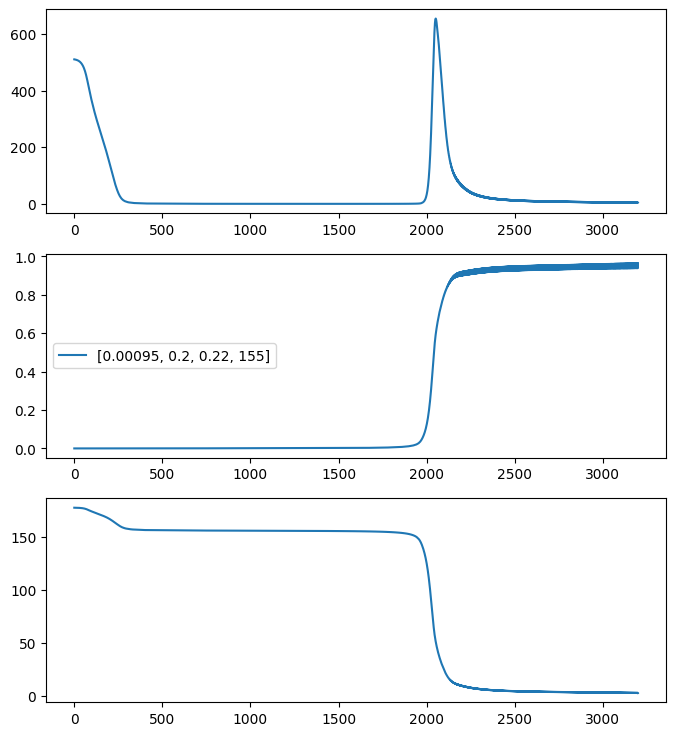

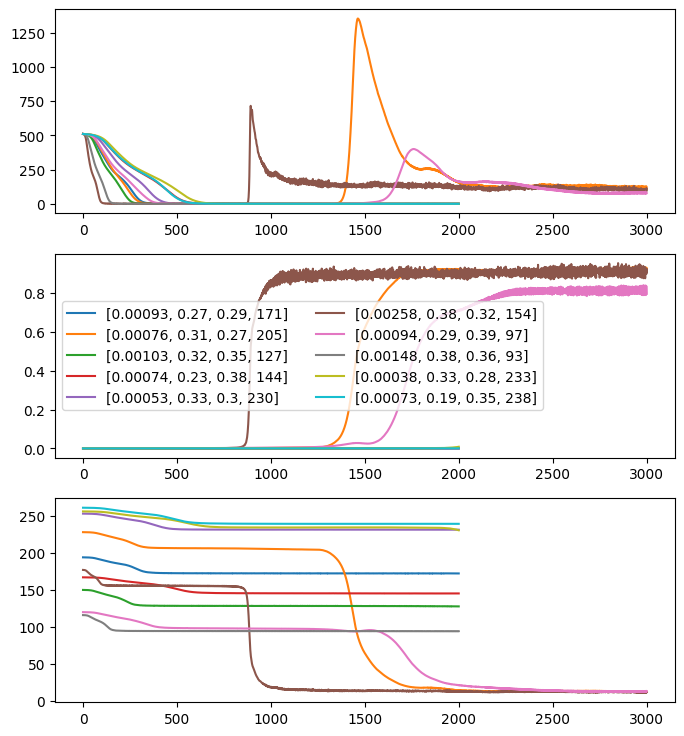

In [115]:
for key, v1 in opt_dict.items():
    
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))
    
    for k, v in v1.items():
        opt = v['opt']
        label=[np.round(x, 2) for x in k]
        label[0] = np.round(k[0], 5)
        ax1.plot(opt.unitarity_scores)
        ax2.plot(opt.mpo_expectations, label=label)
        opt.compute_training_losses()
        ax3.plot(opt.training_losses)
    
    ax2.legend(loc='center left', ncols=2)

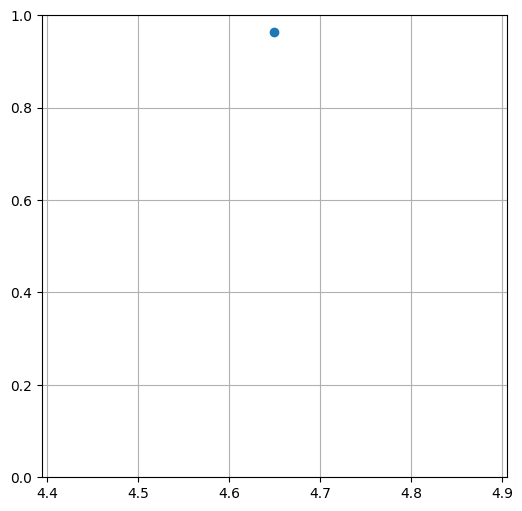

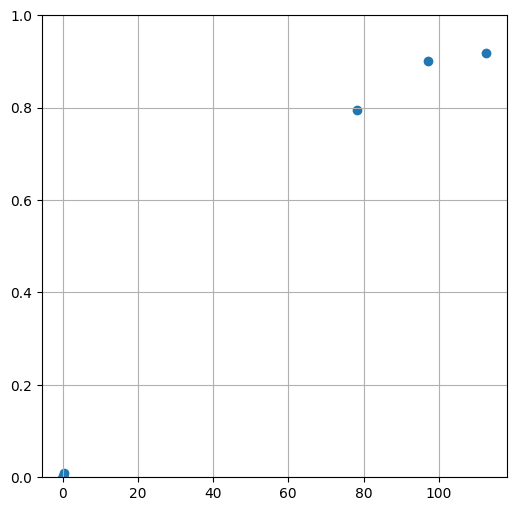

In [116]:
for key, v1 in opt_dict.items():
    
    fig, ax = plt.subplots(figsize=(6, 6))

    final_unitarities = list()
    final_mpo_expectations = list()
    
    for k, v in v1.items():
        opt = v['opt']
        final_unitarities.append(opt.unitarity_scores[-1])
        final_mpo_expectations.append(opt.mpo_expectations[-1])
    
    ax.scatter(final_unitarities, final_mpo_expectations)
    ax.set_ylim(0, 1)
    ax.grid()

## Attempt 3

In [117]:
num_sites = 6

unitarity_learning_rate = 1
overlap_learning_rate = 100

num_iterations = 2000
num_good_sol_followup_iterations = 200
num_potential_sol_followup_iterations = 1000
bond_dimension = 6
num_seeds = 10

In [118]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [119]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [120]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(5e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.3),
    'beta_2': scipy.stats.uniform(0.15, 0.25),
    'overlap_learning_rate': scipy.stats.randint(80, 250)
}

In [121]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [123]:
opt_dict = dict()

for k, case in cases_non_triv_proj_rep.items():
    if (k[1] != 0):
        start = time.time()
        print(k)

        results_dict = dict()
        new_seed_needed = True
        good_sol_found = False

        l=0
        while new_seed_needed:
            start = time.time()
            hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
            print(hyperparams)


            opt = MPOGradientDescent(
                case,
                num_sites,
                bond_dimension,
                unitarity_learning_rate,
                hyperparams['overlap_learning_rate'],
                (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2']),
                random_initial_mpo=True
            )

            j = 0
            need_more_iterations = True
            while need_more_iterations:
                opt.grad_desc_one_step()
    
                j += 1

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
                diverging_sol = get_diverging_sol(unitarity, overlap)
                need_more_iterations = (
                    (not good_sol_found)
                    and (not diverging_sol)
                    and (j<num_iterations)
                )

            if overlap  > 0.1:
                for _ in range(num_potential_sol_followup_iterations):
                    opt.grad_desc_one_step()

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
            
            if good_sol_found:
                for _ in range(num_good_sol_followup_iterations):
                    opt.grad_desc_one_step()

            end = time.time()

            # Saving multiple copies of MPS? This could blow up memory...!
            current_results = {
                'time': (end-start),
                'good_sol': good_sol_found,
                'opt': opt
            }
            
            results_dict[HyperParams(**hyperparams)] = current_results
            print(end - start)
            print(np.real(unitarity))
            print(overlap)
            print()

            l += 1
            new_seed_needed = (
                (not good_sol_found)
                and (l<num_seeds)
            )

        opt_dict[k] = results_dict

(0, 1)
{'alpha': 0.0052361028477904735, 'beta_1': 0.3805240332433597, 'beta_2': 0.37891121210902023, 'overlap_learning_rate': 245}
144.70510983467102
2.808734181298803
0.9247091397427657

(0, 2)
{'alpha': 0.0077513741829491846, 'beta_1': 0.32290293950381344, 'beta_2': 0.23851469300873945, 'overlap_learning_rate': 87}
261.2336769104004
2.984934199962936
0.0006982769606518448

{'alpha': 0.0050437070750015064, 'beta_1': 0.1536628552125704, 'beta_2': 0.22081430039091818, 'overlap_learning_rate': 220}
566.6433250904083
1.9796518705628614
0.00011289755874800292

{'alpha': 0.0007263976519402342, 'beta_1': 0.26797499704196925, 'beta_2': 0.1764606634888301, 'overlap_learning_rate': 82}
710.4684579372406
0.031075890592205724
0.0005351367641530983

{'alpha': 0.002752872169958214, 'beta_1': 0.2804627153643168, 'beta_2': 0.3789212742230966, 'overlap_learning_rate': 181}
807.144434928894
0.4644858557362568
1.2921942513832655e-05

{'alpha': 0.007324082653548879, 'beta_1': 0.24662527247512916, 'beta_2

KeyboardInterrupt: 

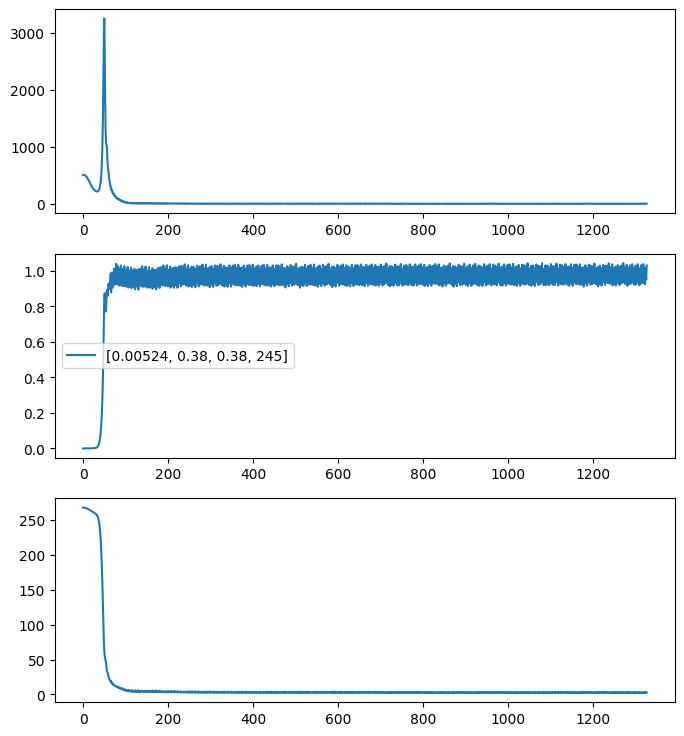

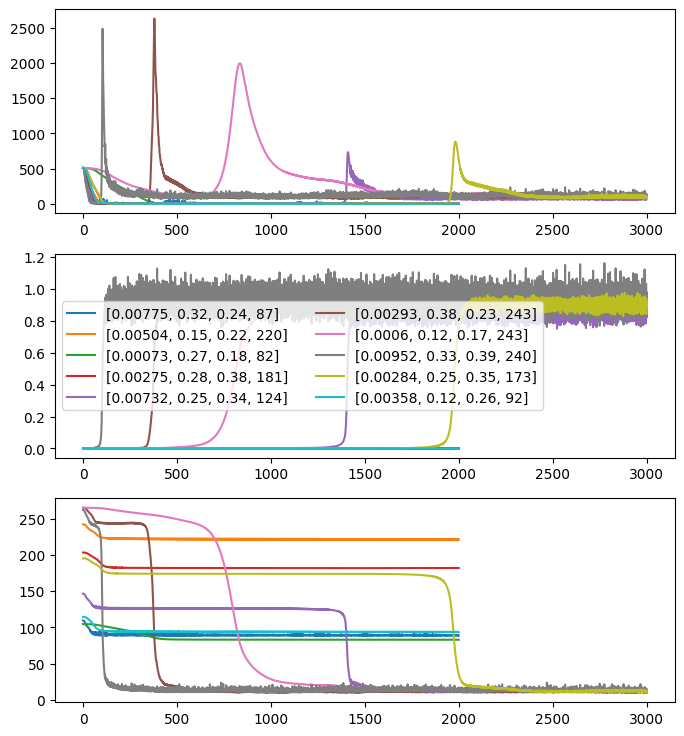

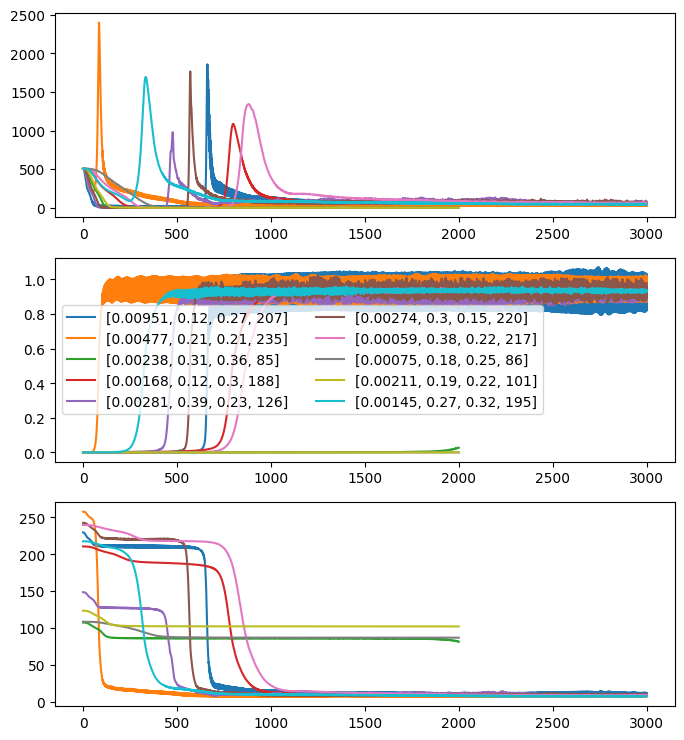

In [124]:
for key, v1 in opt_dict.items():
    
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))
    
    for k, v in v1.items():
        opt = v['opt']
        label=[np.round(x, 2) for x in k]
        label[0] = np.round(k[0], 5)
        ax1.plot(opt.unitarity_scores)
        ax2.plot(opt.mpo_expectations, label=label)
        opt.compute_training_losses()
        ax3.plot(opt.training_losses)
    
    ax2.legend(loc='center left', ncols=2)

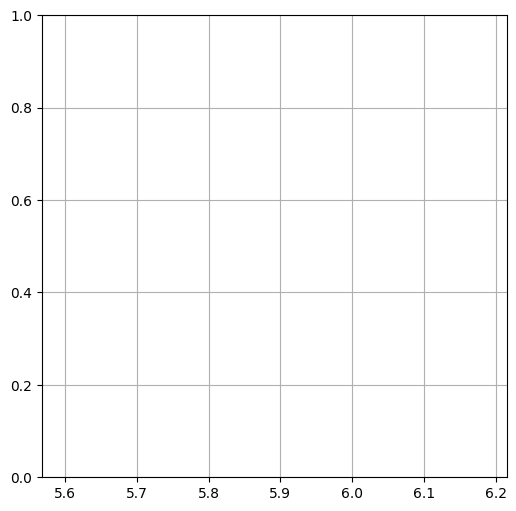

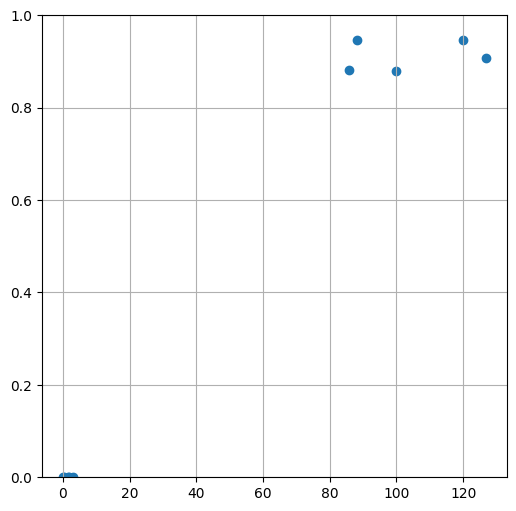

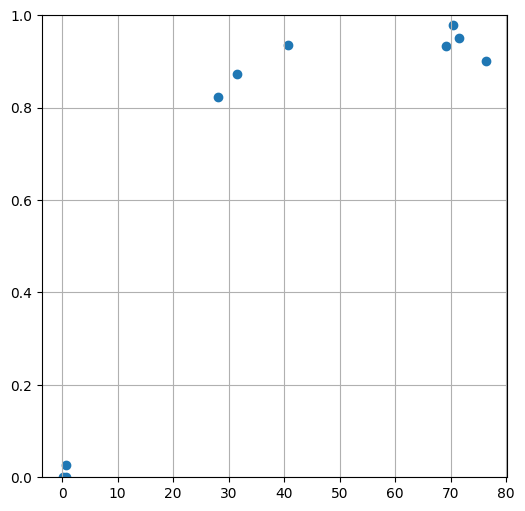

In [125]:
for key, v1 in opt_dict.items():
    
    fig, ax = plt.subplots(figsize=(6, 6))

    final_unitarities = list()
    final_mpo_expectations = list()
    
    for k, v in v1.items():
        opt = v['opt']
        final_unitarities.append(opt.unitarity_scores[-1])
        final_mpo_expectations.append(opt.mpo_expectations[-1])
    
    ax.scatter(final_unitarities, final_mpo_expectations)
    ax.set_ylim(0, 1)
    ax.grid()

## Attempt 4

In [126]:
num_sites = 6

unitarity_learning_rate = 1
overlap_learning_rate = 100

num_iterations = 2000
num_good_sol_followup_iterations = 200
num_potential_sol_followup_iterations = 1000
bond_dimension = 6
num_seeds = 10

In [127]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [128]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [129]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(5e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.05, 0.3),
    'beta_2': scipy.stats.uniform(0.05, 0.25),
    'overlap_learning_rate': scipy.stats.randint(80, 250)
}

In [130]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [131]:
opt_dict = dict()

for k, case in cases_non_triv_proj_rep.items():
    if (k[1] != 0):
        start = time.time()
        print(k)

        results_dict = dict()
        new_seed_needed = True
        good_sol_found = False

        l=0
        while new_seed_needed:
            start = time.time()
            hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
            print(hyperparams)


            opt = MPOGradientDescent(
                case,
                num_sites,
                bond_dimension,
                unitarity_learning_rate,
                hyperparams['overlap_learning_rate'],
                (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2']),
                random_initial_mpo=True
            )

            j = 0
            need_more_iterations = True
            while need_more_iterations:
                opt.grad_desc_one_step()
    
                j += 1

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
                diverging_sol = get_diverging_sol(unitarity, overlap)
                need_more_iterations = (
                    (not good_sol_found)
                    and (not diverging_sol)
                    and (j<num_iterations)
                )

            if overlap  > 0.1:
                for _ in range(num_potential_sol_followup_iterations):
                    opt.grad_desc_one_step()

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
            
            if good_sol_found:
                for _ in range(num_good_sol_followup_iterations):
                    opt.grad_desc_one_step()

            end = time.time()

            # Saving multiple copies of MPS? This could blow up memory...!
            current_results = {
                'time': (end-start),
                'good_sol': good_sol_found,
                'opt': opt
            }
            
            results_dict[HyperParams(**hyperparams)] = current_results
            print(end - start)
            print(np.real(unitarity))
            print(overlap)
            print()

            l += 1
            new_seed_needed = (
                (not good_sol_found)
                and (l<num_seeds)
            )

        opt_dict[k] = results_dict

(0, 1)
{'alpha': 0.003035597103109745, 'beta_1': 0.1335171858656946, 'beta_2': 0.0804785792319125, 'overlap_learning_rate': 191}
232.15112400054932
3.444162036771388
0.922712590591324

(0, 2)
{'alpha': 0.008555862025660221, 'beta_1': 0.05788718230977902, 'beta_2': 0.06984793779914518, 'overlap_learning_rate': 121}
354.73807287216187
42.352058852559594
0.7479370593142749

{'alpha': 0.0012919307083248716, 'beta_1': 0.15183820927356204, 'beta_2': 0.18179163382519364, 'overlap_learning_rate': 113}
202.72588229179382
0.3020569208632651
1.9783010851012215e-06

{'alpha': 0.004817098157627824, 'beta_1': 0.14850634436205298, 'beta_2': 0.1502302435855115, 'overlap_learning_rate': 209}
424.3412981033325
102.28739268332652
0.9966675886213959

{'alpha': 0.0012529565888046356, 'beta_1': 0.34619919734096477, 'beta_2': 0.1614271367186219, 'overlap_learning_rate': 93}
268.502876996994
0.4188627764339117
4.51566212771297e-05

{'alpha': 0.005464963547894014, 'beta_1': 0.20155471472075726, 'beta_2': 0.169

KeyboardInterrupt: 

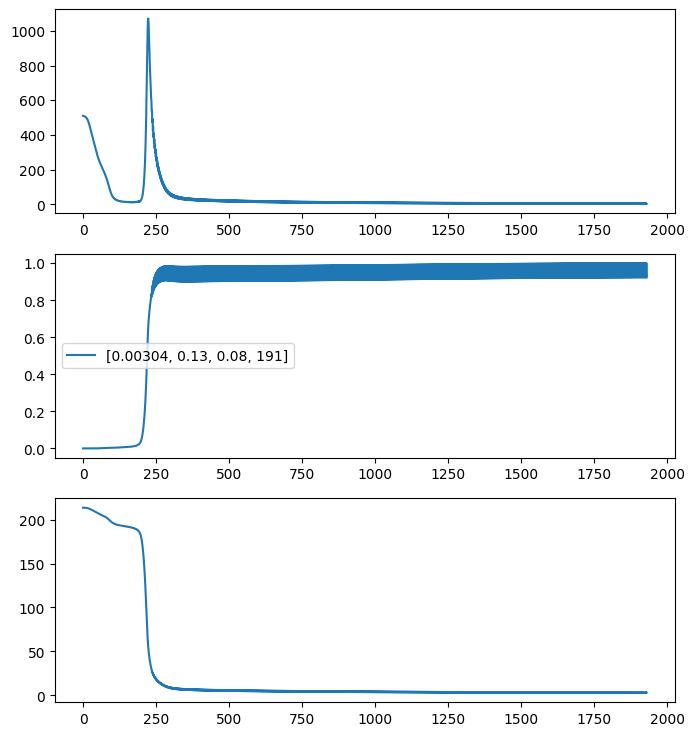

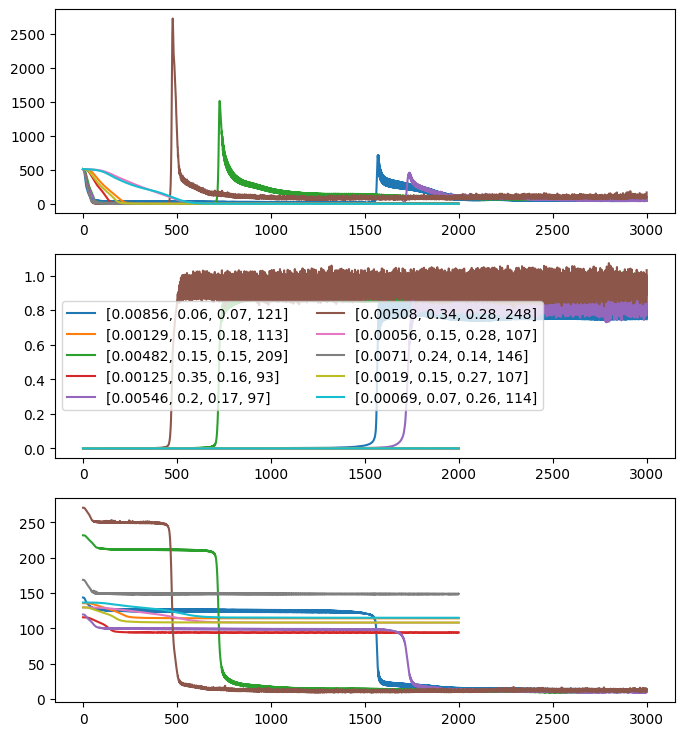

In [132]:
for key, v1 in opt_dict.items():
    
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))
    
    for k, v in v1.items():
        opt = v['opt']
        label=[np.round(x, 2) for x in k]
        label[0] = np.round(k[0], 5)
        ax1.plot(opt.unitarity_scores)
        ax2.plot(opt.mpo_expectations, label=label)
        opt.compute_training_losses()
        ax3.plot(opt.training_losses)
    
    ax2.legend(loc='center left', ncols=2)

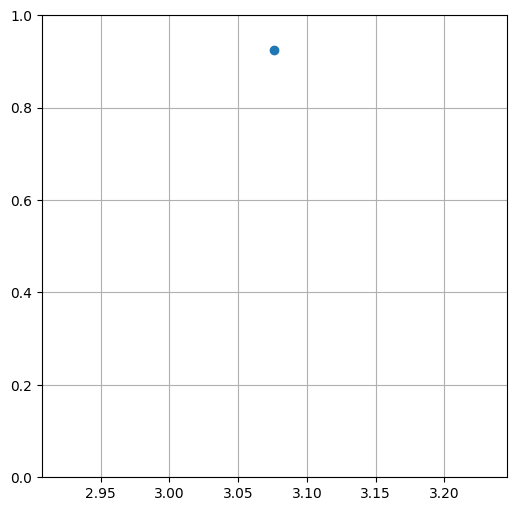

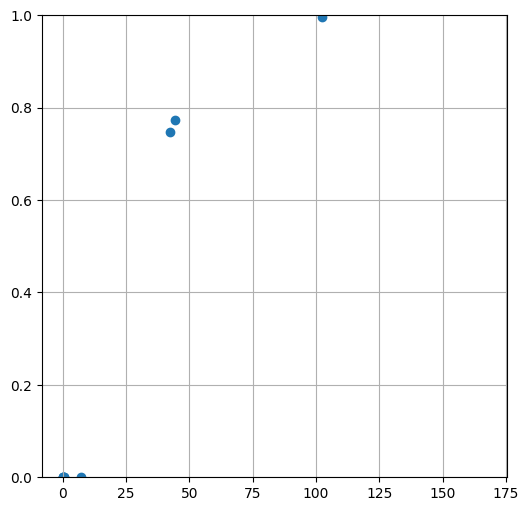

In [133]:
for key, v1 in opt_dict.items():
    
    fig, ax = plt.subplots(figsize=(6, 6))

    final_unitarities = list()
    final_mpo_expectations = list()
    
    for k, v in v1.items():
        opt = v['opt']
        final_unitarities.append(opt.unitarity_scores[-1])
        final_mpo_expectations.append(opt.mpo_expectations[-1])
    
    ax.scatter(final_unitarities, final_mpo_expectations)
    ax.set_ylim(0, 1)
    ax.grid()

## Attempt 5

In [134]:
num_sites = 6

unitarity_learning_rate = 1
overlap_learning_rate = 100

num_iterations = 2000
num_good_sol_followup_iterations = 200
num_potential_sol_followup_iterations = 1000
bond_dimension = 6
num_seeds = 10

In [135]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [136]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [137]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(5e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.05, 0.3),
    'beta_2': scipy.stats.uniform(0.05, 0.25),
    'overlap_learning_rate': scipy.stats.randint(80, 180)
}

In [138]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [139]:
opt_dict = dict()

for k, case in cases_non_triv_proj_rep.items():
    if (k[1] != 0):
        start = time.time()
        print(k)

        results_dict = dict()
        new_seed_needed = True
        good_sol_found = False

        l=0
        while new_seed_needed:
            start = time.time()
            hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
            print(hyperparams)


            opt = MPOGradientDescent(
                case,
                num_sites,
                bond_dimension,
                unitarity_learning_rate,
                hyperparams['overlap_learning_rate'],
                (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2']),
                random_initial_mpo=True
            )

            j = 0
            need_more_iterations = True
            while need_more_iterations:
                opt.grad_desc_one_step()
    
                j += 1

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
                diverging_sol = get_diverging_sol(unitarity, overlap)
                need_more_iterations = (
                    (not good_sol_found)
                    and (not diverging_sol)
                    and (j<num_iterations)
                )

            if overlap  > 0.1:
                for _ in range(num_potential_sol_followup_iterations):
                    opt.grad_desc_one_step()

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
            
            if good_sol_found:
                for _ in range(num_good_sol_followup_iterations):
                    opt.grad_desc_one_step()

            end = time.time()

            # Saving multiple copies of MPS? This could blow up memory...!
            current_results = {
                'time': (end-start),
                'good_sol': good_sol_found,
                'opt': opt
            }
            
            results_dict[HyperParams(**hyperparams)] = current_results
            print(end - start)
            print(np.real(unitarity))
            print(overlap)
            print()

            l += 1
            new_seed_needed = (
                (not good_sol_found)
                and (l<num_seeds)
            )

        opt_dict[k] = results_dict

(0, 1)
{'alpha': 0.0007965451903925549, 'beta_1': 0.29248906278226205, 'beta_2': 0.11153654585047383, 'overlap_learning_rate': 122}
813.2306749820709
1.6176686651576233
0.9290019141831437

(0, 2)
{'alpha': 0.0036070053893690482, 'beta_1': 0.3479033468274712, 'beta_2': 0.16187485036103927, 'overlap_learning_rate': 127}
854.746495962143
75.86694627304314
0.8476559829687998

{'alpha': 0.0025167932981377122, 'beta_1': 0.211212123125591, 'beta_2': 0.05874893496503768, 'overlap_learning_rate': 147}
568.4746596813202
1.1335990065782084
6.62633869974848e-06

{'alpha': 0.00300828736625524, 'beta_1': 0.27944307502205534, 'beta_2': 0.21389259927983206, 'overlap_learning_rate': 95}
571.9527688026428
0.994778233335694
0.0005384665604004718

{'alpha': 0.00966817262153628, 'beta_1': 0.2597970912519752, 'beta_2': 0.15046276029414613, 'overlap_learning_rate': 178}
848.3259079456329
91.70317359270302
0.8523148041443047

{'alpha': 0.0015987647402898092, 'beta_1': 0.08485179746873597, 'beta_2': 0.11220495

KeyboardInterrupt: 

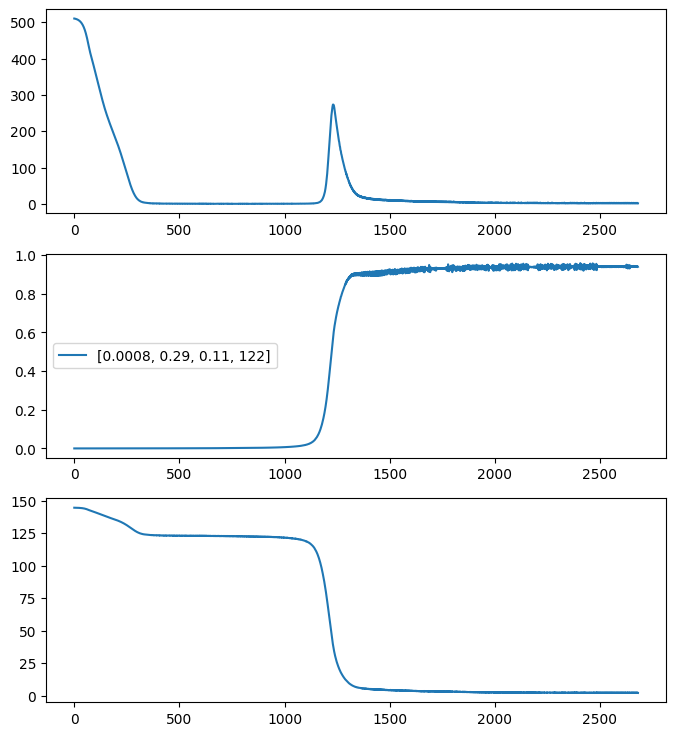

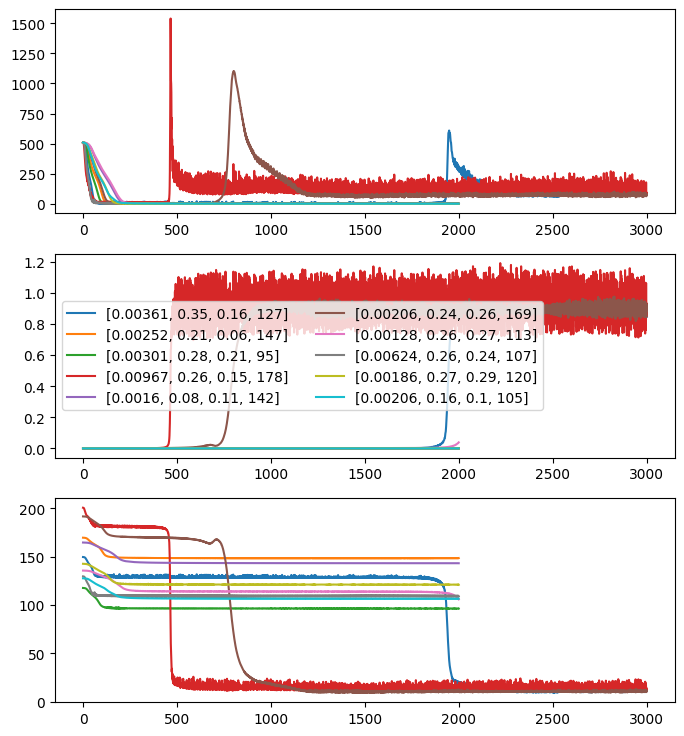

In [140]:
for key, v1 in opt_dict.items():
    
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))
    
    for k, v in v1.items():
        opt = v['opt']
        label=[np.round(x, 2) for x in k]
        label[0] = np.round(k[0], 5)
        ax1.plot(opt.unitarity_scores)
        ax2.plot(opt.mpo_expectations, label=label)
        opt.compute_training_losses()
        ax3.plot(opt.training_losses)
    
    ax2.legend(loc='center left', ncols=2)

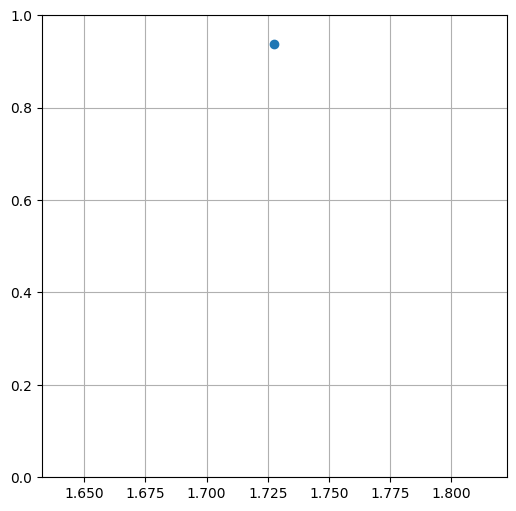

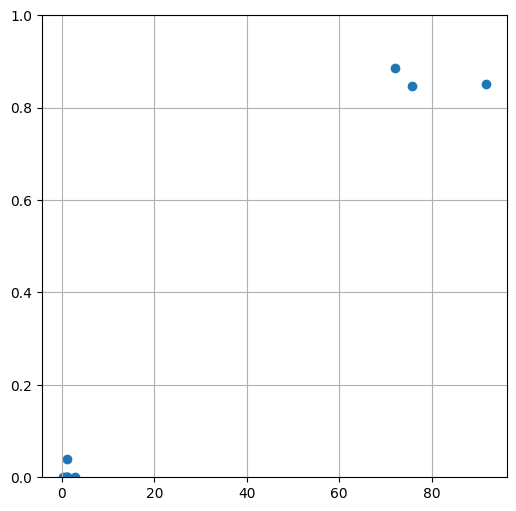

In [141]:
for key, v1 in opt_dict.items():
    
    fig, ax = plt.subplots(figsize=(6, 6))

    final_unitarities = list()
    final_mpo_expectations = list()
    
    for k, v in v1.items():
        opt = v['opt']
        final_unitarities.append(opt.unitarity_scores[-1])
        final_mpo_expectations.append(opt.mpo_expectations[-1])
    
    ax.scatter(final_unitarities, final_mpo_expectations)
    ax.set_ylim(0, 1)
    ax.grid()

# Conclusion
Still have trouble converging...